Environment Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
NORMALIZED_DATA_PATH = PROJECT_ROOT / "dataset" / "normalized"

LABEL_MAP = {
    0: 'normal',
    1: 'security_anomaly',
    2: 'system_failure',
    3: 'performance_issue',
    4: 'network_anomaly',
    5: 'config_error',
    6: 'hardware_issue'
}

Dataset Discovery

In [2]:
metadata_path = NORMALIZED_DATA_PATH / "imbalance_analysis.json"
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        imbalance_data = json.load(f)
    print(f"\n✓ Loaded imbalance analysis from: {metadata_path}")
else:
    imbalance_data = None
    print("\n⚠️  No imbalance analysis found. Run preprocessing first.")

enhanced_files = list(NORMALIZED_DATA_PATH.glob("*_enhanced.csv"))
print(f"\nFound {len(enhanced_files)} enhanced files")

source_data = {}
for file_path in sorted(enhanced_files):
    source_name = file_path.stem.replace('_enhanced', '')
    df = pd.read_csv(file_path)
    
    if 'AnomalyLabel' in df.columns:
        source_data[source_name] = {
            'df': df,
            'labels': df['AnomalyLabel'].values,
            'total': len(df)
        }

print(f"Loaded {len(source_data)} sources with labels")


✓ Loaded imbalance analysis from: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\normalized\imbalance_analysis.json

Found 16 enhanced files
Loaded 16 sources with labels


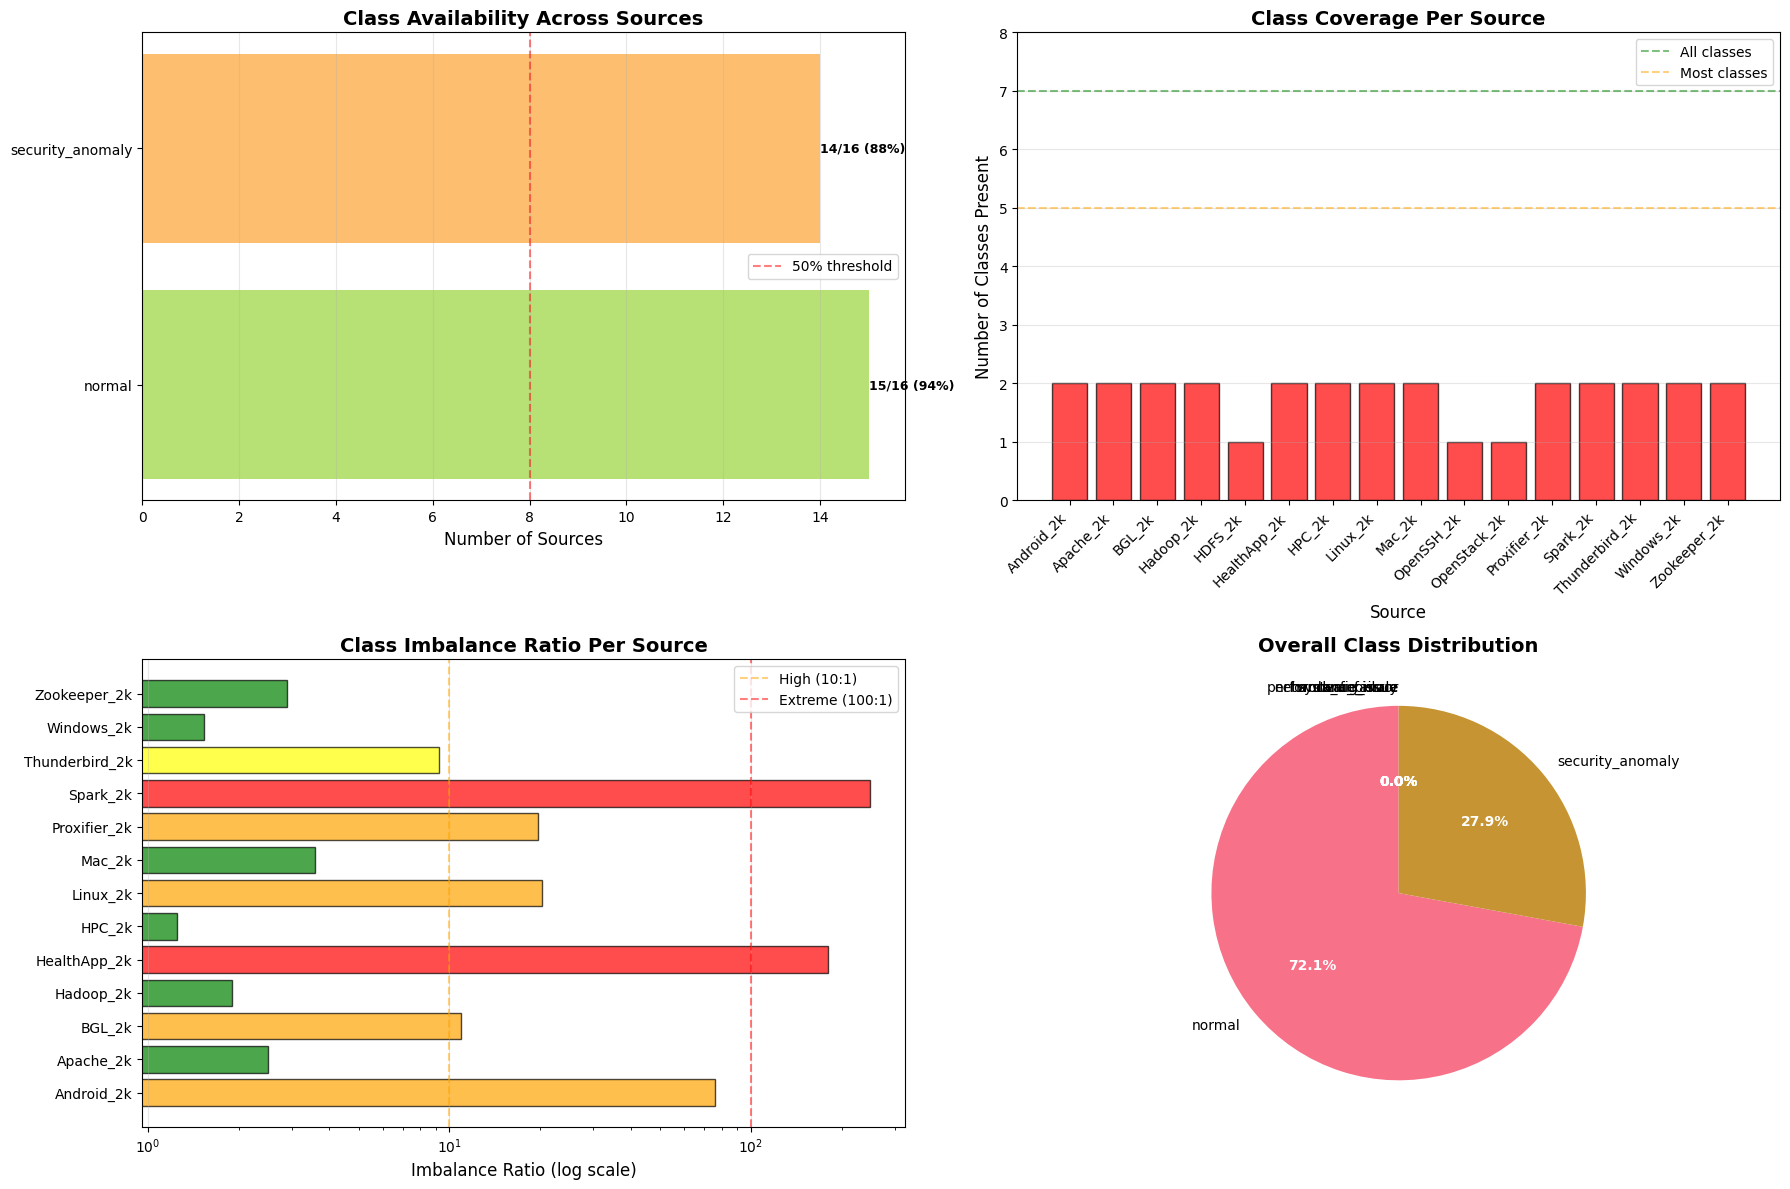


✓ Visualization saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\normalized\imbalance_analysis.png


In [3]:
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

ax = axes[0, 0]
if imbalance_data and 'class_availability' in imbalance_data:
    availability = imbalance_data['class_availability']
    classes = [LABEL_MAP[int(k)] for k in sorted(availability.keys())]
    counts = [len(availability[str(k)]) for k in sorted([int(x) for x in availability.keys()])]
    total_sources = len(source_data)
    
    bars = ax.barh(classes, counts, color=sns.color_palette("RdYlGn_r", len(classes)))
    ax.set_xlabel('Number of Sources', fontsize=12)
    ax.set_title('Class Availability Across Sources', fontsize=14, fontweight='bold')
    ax.axvline(x=total_sources*0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    
    for i, (bar, count) in enumerate(zip(bars, counts)):
        percentage = (count / total_sources * 100) if total_sources > 0 else 0
        ax.text(count, bar.get_y() + bar.get_height()/2, 
                f'{count}/{total_sources} ({percentage:.0f}%)',
                va='center', fontweight='bold', fontsize=9)
    
    ax.legend()
    ax.grid(axis='x', alpha=0.3)

ax = axes[0, 1]
if imbalance_data and 'source_analysis' in imbalance_data:
    source_names = []
    num_classes_present = []
    colors = []
    
    for source, analysis in imbalance_data['source_analysis'].items():
        source_names.append(source.replace('_labeled', '')[:15])
        n_classes = len(analysis['present_classes'])
        num_classes_present.append(n_classes)
        
        if n_classes == 7:
            colors.append('green')
        elif n_classes >= 5:
            colors.append('orange')
        else:
            colors.append('red')
    
    bars = ax.bar(range(len(source_names)), num_classes_present, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Source', fontsize=12)
    ax.set_ylabel('Number of Classes Present', fontsize=12)
    ax.set_title('Class Coverage Per Source', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(source_names)))
    ax.set_xticklabels(source_names, rotation=45, ha='right')
    ax.axhline(y=7, color='green', linestyle='--', alpha=0.5, label='All classes')
    ax.axhline(y=5, color='orange', linestyle='--', alpha=0.5, label='Most classes')
    ax.set_ylim(0, 8)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

ax = axes[1, 0]
if imbalance_data and 'source_analysis' in imbalance_data:
    imbalance_ratios = []
    source_names_imb = []
    
    for source, analysis in imbalance_data['source_analysis'].items():
        if analysis['imbalance_ratio'] > 0:
            source_names_imb.append(source.replace('_labeled', '')[:15])
            imbalance_ratios.append(analysis['imbalance_ratio'])
    
    colors_imb = ['red' if r > 100 else 'orange' if r > 10 else 'yellow' if r > 5 else 'green' 
                  for r in imbalance_ratios]
    
    bars = ax.barh(source_names_imb, imbalance_ratios, color=colors_imb, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Imbalance Ratio (log scale)', fontsize=12)
    ax.set_title('Class Imbalance Ratio Per Source', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.axvline(x=10, color='orange', linestyle='--', alpha=0.5, label='High (10:1)')
    ax.axvline(x=100, color='red', linestyle='--', alpha=0.5, label='Extreme (100:1)')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)

ax = axes[1, 1]
overall_class_dist = {i: 0 for i in range(7)}
for source_name, data in source_data.items():
    unique, counts = np.unique(data['labels'], return_counts=True)
    for label, count in zip(unique, counts):
        overall_class_dist[int(label)] += count

total_samples = sum(overall_class_dist.values())
classes = [LABEL_MAP[i] for i in range(7)]
counts = [overall_class_dist[i] for i in range(7)]
percentages = [(c / total_samples * 100) if total_samples > 0 else 0 for c in counts]

colors_pie = sns.color_palette("husl", 7)
wedges, texts, autotexts = ax.pie(counts, labels=classes, colors=colors_pie,
                                    autopct='%1.1f%%', startangle=90)

ax.set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig(NORMALIZED_DATA_PATH / "imbalance_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved: {NORMALIZED_DATA_PATH / 'imbalance_analysis.png'}")

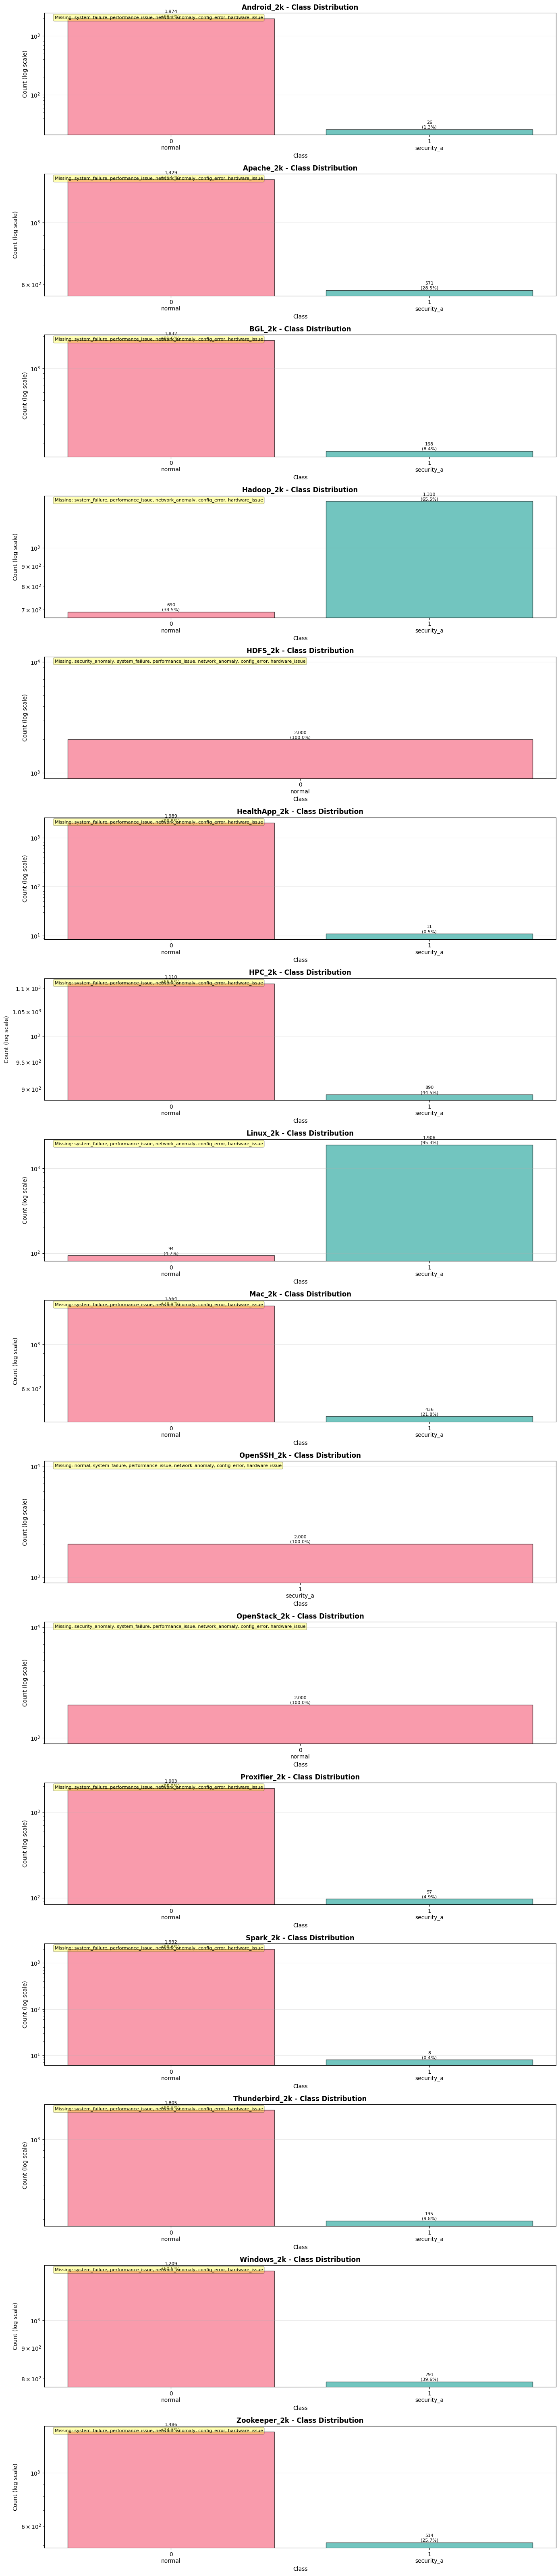

✓ Per-source visualization saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\normalized\per_source_distribution.png


In [4]:
fig, axes = plt.subplots(len(source_data), 1, figsize=(14, 4 * len(source_data)))
if len(source_data) == 1:
    axes = [axes]

for idx, (source_name, data) in enumerate(source_data.items()):
    ax = axes[idx]
    
    unique, counts = np.unique(data['labels'], return_counts=True)
    present_classes = sorted([int(x) for x in unique])
    
    class_names = [f"{i}\n{LABEL_MAP[i][:10]}" for i in present_classes]
    class_counts = [counts[list(unique).index(i)] for i in present_classes]
    
    colors = sns.color_palette("husl", len(present_classes))
    bars = ax.bar(class_names, class_counts, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_title(f'{source_name} - Class Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Class', fontsize=10)
    ax.set_ylabel('Count (log scale)', fontsize=10)
    ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, class_counts):
        height = bar.get_height()
        percentage = (count / data['total'] * 100)
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=8)
    
    missing = [i for i in range(7) if i not in present_classes]
    if missing:
        missing_text = ', '.join([LABEL_MAP[m] for m in missing])
        ax.text(0.02, 0.98, f'Missing: {missing_text}',
                transform=ax.transAxes, fontsize=8, va='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig(NORMALIZED_DATA_PATH / "per_source_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Per-source visualization saved: {NORMALIZED_DATA_PATH / 'per_source_distribution.png'}")

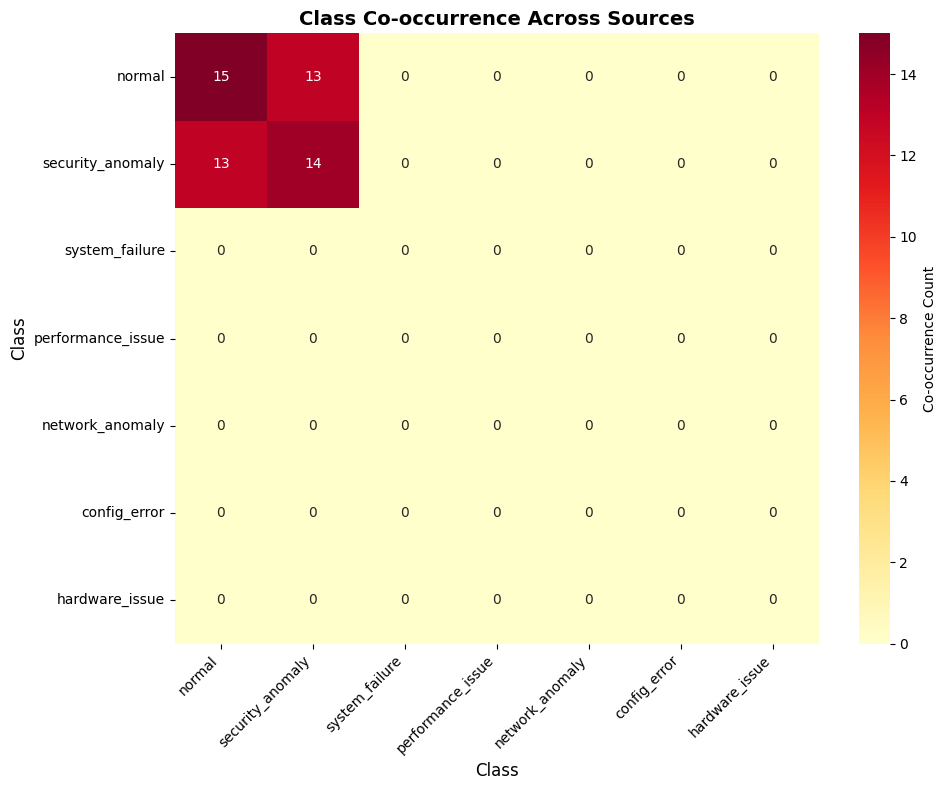

✓ Co-occurrence matrix saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\normalized\class_cooccurrence.png


In [5]:
co_occurrence = np.zeros((7, 7))
for source_name, data in source_data.items():
    present = sorted(set(data['labels']))
    for i in present:
        for j in present:
            co_occurrence[int(i), int(j)] += 1

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(co_occurrence, annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=[LABEL_MAP[i] for i in range(7)],
            yticklabels=[LABEL_MAP[i] for i in range(7)],
            cbar_kws={'label': 'Co-occurrence Count'},
            ax=ax)
ax.set_title('Class Co-occurrence Across Sources', fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(NORMALIZED_DATA_PATH / "class_cooccurrence.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Co-occurrence matrix saved: {NORMALIZED_DATA_PATH / 'class_cooccurrence.png'}")

In [6]:
print("\n1. OVERALL CLASS STATISTICS")
print("-" * 60)
total_overall = sum(overall_class_dist.values())
for cls in range(7):
    count = overall_class_dist[cls]
    percentage = (count / total_overall * 100) if total_overall > 0 else 0
    sources_with = len([s for s in source_data.keys() if cls in source_data[s]['labels']])
    print(f"{cls} ({LABEL_MAP[cls]}):")
    print(f"  Total samples: {count:,} ({percentage:.2f}%)")
    print(f"  Available in: {sources_with}/{len(source_data)} sources")
    if count == 0:
        print(f"  ⚠️ MISSING FROM ALL SOURCES!")
    elif percentage < 1:
        print(f"  ⚠️ RARE CLASS (<1% of data)")
    elif sources_with < len(source_data) * 0.3:
        print(f"  ⚠️ LOW AVAILABILITY")

print("\n2. SOURCE-LEVEL STATISTICS")
print("-" * 60)
for source_name, data in source_data.items():
    unique, counts = np.unique(data['labels'], return_counts=True)
    present = sorted([int(x) for x in unique])
    missing = [i for i in range(7) if i not in present]
    
    class_counts = [counts[list(unique).index(i)] for i in present]
    if len(class_counts) > 1:
        imb_ratio = max(class_counts) / min(class_counts)
    else:
        imb_ratio = 0
    
    print(f"\n{source_name}:")
    print(f"  Total samples: {data['total']:,}")
    print(f"  Classes present: {len(present)}/7")
    print(f"  Imbalance ratio: {imb_ratio:.2f}:1", end="")
    if imb_ratio > 100:
        print(" ⚠️ EXTREME")
    elif imb_ratio > 10:
        print(" ⚠️ HIGH")
    elif imb_ratio > 5:
        print(" ⚠️ MODERATE")
    else:
        print(" ✓")
    
    if missing:
        print(f"  Missing classes: {', '.join([LABEL_MAP[m] for m in missing])}")
    
    print(f"  Class distribution:")
    for cls in present:
        count = counts[list(unique).index(cls)]
        pct = (count / data['total'] * 100)
        print(f"    {cls} ({LABEL_MAP[cls]}): {count:,} ({pct:.2f}%)")

print("\n3. IMBALANCE SEVERITY CLASSIFICATION")
print("-" * 60)
if imbalance_data and 'source_analysis' in imbalance_data:
    extreme = []
    high = []
    moderate = []
    low = []
    
    for source, analysis in imbalance_data['source_analysis'].items():
        ratio = analysis['imbalance_ratio']
        source_short = source.replace('_labeled', '')
        if ratio > 100:
            extreme.append(source_short)
        elif ratio > 10:
            high.append(source_short)
        elif ratio > 5:
            moderate.append(source_short)
        else:
            low.append(source_short)
    
    print(f"Extreme (>100:1): {len(extreme)} sources")
    if extreme:
        print(f"  {', '.join(extreme)}")
    
    print(f"\nHigh (10-100:1): {len(high)} sources")
    if high:
        print(f"  {', '.join(high)}")
    
    print(f"\nModerate (5-10:1): {len(moderate)} sources")
    if moderate:
        print(f"  {', '.join(moderate)}")
    
    print(f"\nLow (<5:1): {len(low)} sources")
    if low:
        print(f"  {', '.join(low)}")


1. OVERALL CLASS STATISTICS
------------------------------------------------------------
0 (normal):
  Total samples: 23,077 (72.12%)
  Available in: 15/16 sources
1 (security_anomaly):
  Total samples: 8,923 (27.88%)
  Available in: 14/16 sources
2 (system_failure):
  Total samples: 0 (0.00%)
  Available in: 0/16 sources
  ⚠️ MISSING FROM ALL SOURCES!
3 (performance_issue):
  Total samples: 0 (0.00%)
  Available in: 0/16 sources
  ⚠️ MISSING FROM ALL SOURCES!
4 (network_anomaly):
  Total samples: 0 (0.00%)
  Available in: 0/16 sources
  ⚠️ MISSING FROM ALL SOURCES!
5 (config_error):
  Total samples: 0 (0.00%)
  Available in: 0/16 sources
  ⚠️ MISSING FROM ALL SOURCES!
6 (hardware_issue):
  Total samples: 0 (0.00%)
  Available in: 0/16 sources
  ⚠️ MISSING FROM ALL SOURCES!

2. SOURCE-LEVEL STATISTICS
------------------------------------------------------------

Android_2k:
  Total samples: 2,000
  Classes present: 2/7
  Imbalance ratio: 75.92:1 ⚠️ HIGH
  Missing classes: system_failu

In [7]:
strategies = []

rare_classes = [cls for cls, count in overall_class_dist.items() 
                if count < total_overall * 0.01 and count > 0]
missing_classes = [cls for cls, count in overall_class_dist.items() if count == 0]

if missing_classes:
    strategies.append("\n🔴 MISSING CLASSES DETECTED:")
    strategies.append(f"   Classes {missing_classes} ({[LABEL_MAP[c] for c in missing_classes]}) have NO samples")
    strategies.append("   → REDUCE to classes with data only")
    strategies.append("   → OR collect/synthesize data for missing classes")
    strategies.append(f"   → Recommend training with {7 - len(missing_classes)} classes only")

if rare_classes:
    strategies.append(f"\n🟡 RARE CLASSES ({len(rare_classes)}):")
    strategies.append(f"   Classes: {[LABEL_MAP[c] for c in rare_classes]}")
    strategies.append("   → Use SMOTE with k=min(5, min_class_size-1)")
    strategies.append("   → Apply strong class weights")
    strategies.append("   → Consider focal loss (gamma=2)")
    strategies.append("   → Use stratified k-fold CV")

extreme_sources = [s for s, a in (imbalance_data.get('source_analysis', {}) or {}).items() 
                   if a.get('imbalance_ratio', 0) > 100]
if extreme_sources:
    strategies.append(f"\n🔴 EXTREME IMBALANCE ({len(extreme_sources)} sources):")
    strategies.append("   → SMOTE with BorderlineSMOTE variant")
    strategies.append("   → Class weights: compute_class_weight('balanced')")
    strategies.append("   → Ensemble: train separate models per imbalance level")
    strategies.append("   → For BERT: use weighted CrossEntropyLoss")

if len(source_data) > 1:
    strategies.append("\n📊 CROSS-SOURCE TRAINING:")
    sources_all_classes = sum(1 for s, d in source_data.items() 
                              if len(set(d['labels'])) >= 6)
    strategies.append(f"   {sources_all_classes}/{len(source_data)} sources have 6+ classes")
    
    if sources_all_classes < len(source_data):
        strategies.append("   → Use source-specific validation splits")
        strategies.append("   → Test on sources with most classes first")
        strategies.append("   → Consider hierarchical training: binary → multi-class")

strategies.append("\n✅ RECOMMENDED APPROACH:")
strategies.append("   1. Filter to classes with sufficient data (>50 samples)")
strategies.append("   2. Use SMOTE only for minority classes (<10% of data)")
strategies.append("   3. Apply class weights in all models")
strategies.append("   4. Use macro F1 as primary metric (not accuracy)")
strategies.append("   5. Stratified cross-validation (min 3 folds)")
strategies.append("   6. Monitor per-class metrics separately")

for strategy in strategies:
    print(strategy)


🔴 MISSING CLASSES DETECTED:
   Classes [2, 3, 4, 5, 6] (['system_failure', 'performance_issue', 'network_anomaly', 'config_error', 'hardware_issue']) have NO samples
   → REDUCE to classes with data only
   → OR collect/synthesize data for missing classes
   → Recommend training with 2 classes only

🔴 EXTREME IMBALANCE (2 sources):
   → SMOTE with BorderlineSMOTE variant
   → Class weights: compute_class_weight('balanced')
   → Ensemble: train separate models per imbalance level
   → For BERT: use weighted CrossEntropyLoss

📊 CROSS-SOURCE TRAINING:
   0/16 sources have 6+ classes
   → Use source-specific validation splits
   → Test on sources with most classes first
   → Consider hierarchical training: binary → multi-class

✅ RECOMMENDED APPROACH:
   1. Filter to classes with sufficient data (>50 samples)
   2. Use SMOTE only for minority classes (<10% of data)
   3. Apply class weights in all models
   4. Use macro F1 as primary metric (not accuracy)
   5. Stratified cross-validation

In [8]:
viable_classes = [cls for cls, count in overall_class_dist.items() 
                  if count >= 50]
recommended_classes = [cls for cls, count in overall_class_dist.items() 
                       if count >= 100 and len([s for s in source_data.keys() 
                       if cls in source_data[s]['labels']]) >= len(source_data) * 0.3]

print(f"\nViable classes (≥50 samples): {len(viable_classes)}/7")
print(f"  Classes: {[LABEL_MAP[c] for c in viable_classes]}")

print(f"\nRecommended classes (≥100 samples, ≥30% source coverage): {len(recommended_classes)}/7")
print(f"  Classes: {[LABEL_MAP[c] for c in recommended_classes]}")

if len(recommended_classes) < 7:
    print(f"\nConsider reducing from 7 to {len(recommended_classes)} classes")
    print(f"   Train only on: {recommended_classes}")
else:
    print(f"\n✓ All 7 classes have sufficient data for training")

optimal_config = {
    'num_original_classes': 7,
    'viable_classes': viable_classes,
    'recommended_classes': recommended_classes,
    'num_recommended': len(recommended_classes),
    'overall_class_distribution': overall_class_dist,
    'total_samples': total_overall,
    'requires_smote': len(rare_classes) > 0,
    'requires_class_weights': True,
    'recommended_min_samples': 100,
    'timestamp': str(pd.Timestamp.now())
}


Viable classes (≥50 samples): 2/7
  Classes: ['normal', 'security_anomaly']

Recommended classes (≥100 samples, ≥30% source coverage): 2/7
  Classes: ['normal', 'security_anomaly']

Consider reducing from 7 to 2 classes
   Train only on: [0, 1]


In [9]:
def convert(o):
    if isinstance(o, (np.int64, np.int32)):
        return int(o)
    elif isinstance(o, (np.float64, np.float32)):
        return float(o)
    elif isinstance(o, (np.bool_)):
        return bool(o)
    elif isinstance(o, (np.ndarray, list)):
        return [convert(x) for x in o]
    elif isinstance(o, dict):
        return {k: convert(v) for k, v in o.items()}
    return o

optimal_config = convert(optimal_config)

config_path = NORMALIZED_DATA_PATH / "optimal_class_config.json"
with open(config_path, 'w') as f:
    json.dump(optimal_config, f, indent=2)

print(f"Optimal configuration saved: {config_path}")

Optimal configuration saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\normalized\optimal_class_config.json
